In [1]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import json
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Seaborn e MatplotLib | Graficos
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

<center><img src="ml_lfcl.png"></center>


---
# 1. Data collection, Data Cleaning & Feature Engineering

### Método de **Feature Engeneering** e **Limpeza de Dados**

In [2]:
def feature_engeneering(df):
    df_eng = df.copy()

    # --- LIMPEZA INICIAL ---
    df_eng = df_eng.drop_duplicates()
    df_eng['hp'] = df['engine'].str.extract(r'(\d+\.?\d*)HP', expand=False).astype(float)
    df_eng['liters'] = df['engine'].str.extract(r'(\d+\.?\d*)L\s', expand=False).astype(float)

    # --- Idade e Uso ---
    var_ano_atual = date.today().year
    df_eng['car_age'] = var_ano_atual - df_eng['model_year']
    df_eng['car_age'] = df_eng['car_age'].replace(0, 1)

    # --- Cilindrada ---
    df_eng['cylinders'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False)
    df_eng['cylinders'] = df_eng['cylinders'].fillna(df['engine'].str.extract(r'V(\d+)', expand=False))
    df_eng['cylinders'] = df_eng['cylinders'].astype(float)

    # --- Tecnologias de Motor ---
    df_eng['is_turbo'] = df['engine'].str.contains(r'(?i)turbo', na=False).astype(int)
    df_eng['turbo_type'] = df['engine'].str.extract(r'(Twin Turbo|Turbo)', expand=False)
    df_eng['valve_train'] = df['engine'].str.extract(r'(DOHC|OHV|SOHC)', expand=False) 
    df_eng['fuel_injection'] = df['engine'].str.extract(r'(PDI|GDI|MPFI)', expand=False)

    # --- Miles per year
    df_eng['miles_p_year'] = df_eng['milage'] / df_eng['car_age']

    # --- FUEL TYPE ---
    def clean_fuel(val):
        s = str(val).lower()
        if 'hybrid' in s:
            return 'Hybrid'
        elif 'not supported' in s:
            return 'EV'
        else:
            return val
    df_eng['fuel_type'] = df_eng['fuel_type'].apply(clean_fuel)

    # --- TRANSMISSION TYPE ---
    def clean_transmission(val):
        s = str(val).lower()
        if 'automatic' in s or 'a/t' in s or 'cvt' in s:
            return 'Automatico'
        elif 'manual' in s or 'm/t' in s:
            return 'Manual'
        else:
            return 'Outro'
    df_eng['transmission_type'] = df_eng['transmission'].apply(clean_transmission)
    
    # --- Tratamento de Nulos ---
    df_eng['clean_title'] = df_eng['clean_title'].replace('Unknown', 'No') #Vazio passsa a ser "No"
    
    cols_texto = df_eng.select_dtypes(include=['object']).columns
    df_eng[cols_texto] = df_eng[cols_texto].replace('-', 'Unknown').fillna('Unknown')

    # 1. Eficiência do motor
    # Evitar divisão por zero somando um valor ínfimo
    df_eng['hp_per_liter'] = df_eng['hp'] / (df_eng['liters'] + 0.001)

    # 2. Rácio de Potência por Cilindro
    df_eng['hp_per_cylinder'] = df_eng['hp'] / (df_eng['cylinders'] + 0.001)

    # 3. Quilometragem (Milage)
    # A milage tem uma distribuição muito "cauda longa". O Log ajuda o modelo a ver melhor as diferenças.
    df_eng['milage'] = np.log(df_eng['milage'])

    return df_eng

In [3]:
# Recolha os Dados
df_treino = pd.read_csv('dados/train.csv', index_col='id')
df_teste = pd.read_csv('dados/test.csv', index_col='id')

print("✓ Dados lidos com Sucesso!")

✓ Dados lidos com Sucesso!


In [4]:
# Aplicar feature engineering e Limpeza de dados
df_treino_eng = feature_engeneering(df_treino)
df_teste_eng = feature_engeneering(df_teste)

print("✓ Feature Engineering Aplicado com Sucesso!")

✓ Feature Engineering Aplicado com Sucesso!


In [5]:
df_treino_eng.head(1)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,car_age,cylinders,is_turbo,turbo_type,valve_train,fuel_injection,miles_p_year,transmission_type,hp_per_liter,hp_per_cylinder
id,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,12.269047,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,19,4.0,0,Unknown,Unknown,Unknown,11210.526316,Automatico,107.432854,42.989253


In [6]:
df_teste_eng.head(1)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,car_age,cylinders,is_turbo,turbo_type,valve_train,fuel_injection,miles_p_year,transmission_type,hp_per_liter,hp_per_cylinder
id,,,,,,,,,,,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,11.492723,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,...,11,4.0,0,Unknown,Unknown,Unknown,8909.090909,Automatico,119.94003,59.985004


In [7]:
# Separar target
y = np.log(df_treino_eng['price'])
X = df_treino_eng
X_test = df_teste_eng.copy()

# Tipos de Features Relevantes para Previsao
features_numericas = ['hp', 'liters', 'car_age', 'cylinders', 'miles_p_year','milage', 'model_year', 'is_turbo']

# Criar dataset numérico
X_num = X[features_numericas].fillna(0)
X_test_num = X_test[features_numericas].fillna(0)

In [8]:
# Encondificar features categoricas | Tornar valores de texto em numéricos
features_categoricas = ['brand', 'model', 'fuel_type', 'transmission_type', 
                           'clean_title', 'turbo_type', 'valve_train', 'fuel_injection','accident']

print("--- Valores Únicos por Coluna (Antes de Enconding) ---")
for col in features_categoricas:
    unicos = df_treino_eng[col].unique()
    print(f"\nColuna: {col} ({len(unicos)} valores)")
    print(unicos)

--- Valores Únicos por Coluna (Antes de Enconding) ---

Coluna: brand (57 valores)
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

Coluna: model (1897 valores)
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

Coluna: fuel_type (7 valores)
['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' '–' 'EV']

Coluna: transmission_type (3 valores)
['Automatico' 'Outro' 'Manual']

Coluna: clean_title (2 valores)
['Yes' 'Unknown']

Coluna: turbo_

In [9]:
# Preparar features Categoricas
X_cat = X[features_categoricas].copy().astype(str)
X_test_cat = X_test[features_categoricas].copy().astype(str)

X_cat = X_cat.replace('–', 'Unknown')
X_test_cat = X_test_cat.replace('–', 'Unknown')

# Encoding via Mapeamento (Pandas)
for col in features_categoricas:
    # Criar o dicionário baseado no treino: {valor: indice}
    # Ordenar alfabeticamente garante que o encoding seja consistente
    unique_values = sorted(X_cat[col].unique())
    mapping = {val: i for i, val in enumerate(unique_values)}
    
    # Aplicar no Treino
    X_cat[col] = X_cat[col].map(mapping)
    
    # Aplicar no Teste
    # .map() deixa NaN se o valor não existir no mapping. 
    # Usamos .fillna(-1) para novas categorias no teste.
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(-1).astype(int)

print("✓ Encoding Aplicado com Sucesso!")

✓ Encoding Aplicado com Sucesso!


In [10]:
print("--- Valores Únicos por Coluna (Depois de Enconding) ---")
for col in sorted(features_categoricas):
    unicos = pd.Series(X_cat[col].unique()).sort_values().tolist()  # Converte para lista
    print(f"\nColuna: {col} ({len(unicos)} valores)")
    print(unicos)

--- Valores Únicos por Coluna (Depois de Enconding) ---

Coluna: accident (3 valores)
[0, 1, 2]

Coluna: brand (57 valores)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

Coluna: clean_title (2 valores)
[0, 1]

Coluna: fuel_injection (4 valores)
[0, 1, 2, 3]

Coluna: fuel_type (6 valores)
[0, 1, 2, 3, 4, 5]

Coluna: model (1897 valores)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 11

In [11]:
# Concatenar features | Features a serem utilizadas para generalização
X_final = pd.concat([X_num, X_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [12]:
X_final.head(1)

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
0,172.0,1.6,19,4.0,11210.526316,12.269047,2007,0,31,495,3,0,1,2,3,3,1


In [13]:
X_test_final.head(1)

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
188533,240.0,2.0,11,4.0,8909.090909,11.492723,2015,0,26,1390,3,0,1,2,3,3,1


---
# 2. Model Training & Evaluation

### Método de **Definição dos Modelos** - Dicionário com objetos dos modelos de previsão.

In [14]:
def obter_modelos():
    modelos = {
        'Linear Regression': LinearRegression(),

        #'KNN': KNeighborsRegressor(),

        #'Decision Tree': DecisionTreeRegressor(random_state=42),

        #'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),

        #'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),

        #'SVR Linear': SVR(kernel='linear'),

        #'MLP Small': MLPRegressor(random_state=42, early_stopping=True),
    }

    return modelos

### Métodos para **"GridSearchCV"** - Otimização de Hipérparametrso

In [15]:
def obter_params_grid(nome_modelo):
    grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1],
            'positive': [True, False]
        },
        'KNN': {
            'n_neighbors': [3, 11],             #'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]                         # 1=Manhattan, 2=Euclidean
        },
        'Decision Tree': {
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['squared_error']
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'n_estimators': [900, 1000, 1100],             #'n_estimators': [100, 500, 1000],
            'learning_rate': [0.01, 0.01, 0.1],          #'learning_rate': [0.01, 0.01, 0.1],
            'max_depth': [2, 3, 4],
        },
        'SVR Linear': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.5]
        },
        'MLP Small': {
            'hidden_layer_sizes': [(50,50,50), (100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.05],
        }
    }
    return grids.get(nome_modelo, {})

A **Otimização de Hiperparâmetros, ou Hyperparameter Tuning em ingles**, é o processo de encontrar as melhores configurações para um modelo de Machine Learning, ajustando-as sistematicamente para otimizar o seu desempenho, precisão e capacidade de generalização. Os hiperparâmetros são definidos externamente antes da aprendizagem começar, servindo como o "manual de instruções" que molda o comportamento do algoritmo.

Para cada modelo, é definida uma grelha de valores para os hiperparâmetros pretendidos e, posteriormente, com a ajuda de Cross Validation (Validação Cruzada), o modelo é testado em diferentes subconjuntos de dados. No caso do GridSearchCV, o sistema executa uma pesquisa exaustiva, realizando todas as combinações possíveis da grelha para identificar qual delas maximiza uma métrica de desempenho específica, neste caso o RMSE (Root Mean Squared Error).

In [16]:
from sklearn.model_selection import KFold

def executar_grid_search(modelo, nome, X_train, y_train, X_val, y_val):
    print(f"\n A iniciar GridSearch para : {nome}")
    
    # Obter a grelha de parâmetros para o modelo específico
    param_grid = obter_params_grid(nome) 

    # 1. Definir a estratégia de Cross-Validation para Regressão
    # shuffle=True é importante para não viciar o treino pela ordem dos dados
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=modelo,
        param_grid=param_grid,
        cv=kf,  # <--- Agora utiliza o objeto KFold
        scoring='neg_root_mean_squared_error',
        verbose=3,
        n_jobs=-1
    )

    # Executar o treino com procura exaustiva
    grid_search.fit(X_train, y_train)
    melhor_modelo = grid_search.best_estimator_

    # 2. Avaliação dos resultados
    y_pred_train = melhor_modelo.predict(X_train)
    y_pred_val = melhor_modelo.predict(X_val)

    # Cálculo do RMSE (Root Mean Squared Error)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)

    print(f"\n======== {nome} ========")
    print(f"Melhores Parâmetros: {grid_search.best_params_}")
    print(f"\n▶ RMSE Treino: {rmse_train:.4f}")
    print(f"\n▶ RMSE Validação: {rmse_val:.4f}")

    return {
        'nome': nome,
        'rmse_train': rmse_train,
        'rmse_val': rmse_val,
        'modelo_treinado': melhor_modelo
    }

### Método com **Grafico de Dispersao** (Visualizacao de Previsao vs Real)

In [17]:
def grafico_dispersao(nome_modelo, modelo_obj, X_val, y_val, usar_scaled_viz=False, X_val_scaled=None, ax=None):
    """
    Visualiza previsões vs valores reais utilizando Seaborn.
    """
    # 1. Gerar previsões
    y_pred = modelo_obj.predict(X_val_scaled if usar_scaled_viz else X_val)

    # 2. Garantir que temos um eixo para desenhar
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # 3. Plotar com Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=ax, alpha=0.6, s=40, color='royalblue', label='Previsões')
    
    # 4. Linha de Perfeição (y = x)
    lims = [y_val.min(), y_val.max()]
    ax.plot(lims, lims, color='red', linestyle='--', lw=2, label='Perfect Regressor')

    # 5. Estética do gráfico
    ax.set_title(f'Previsões vs Real - {nome_modelo}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor Real (log)', fontsize=10)
    ax.set_ylabel('Valor Previsto (log)', fontsize=10)
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, alpha=0.3)

In [18]:
### Método com **Grafy_ico de Dispersao** (Visualizacao de Previsao vs Real)

In [19]:
def grafico_comparativo_por_indice(nome_modelo, modelo_obj, X_val, y_val, usar_scaled_viz=False, X_val_scaled=None, ax=None, n_amostra=50):
    """
    Mostra os valores Reais e Previstos para cada índice (casa) individualmente.
    """
    # 1. Gerar previsões
    y_pred = modelo_obj.predict(X_val_scaled if usar_scaled_viz else X_val)
    
    # 2. Criar um DataFrame temporário para organizar os dados
    # Resetamos o índice para ter uma contagem de 0 a N (as 'casas')
    df_comp = pd.DataFrame({
        'Real': y_val.values if hasattr(y_val, 'values') else y_val,
        'Previsto': y_pred
    }).reset_index(drop=True)
    
    # Selecionar apenas uma amostra para o gráfico não ficar "sujo"
    df_amostra = df_comp.head(n_amostra)
    
    # Preparar dados para o Seaborn (formato 'long')
    df_melted = df_amostra.reset_index().melt(id_vars='index', value_vars=['Real', 'Previsto'], 
                                              var_name='Tipo', value_name='Valor (log)')

    # 3. Configurar o eixo
    if ax is None:
        plt.figure(figsize=(12, 5))
        ax = plt.gca()

    # 4. Plotar com Seaborn
    # Usamos lineplot com marcadores para ver a ligação entre as casas
    sns.lineplot(data=df_melted, x='index', y='Valor (log)', hue='Tipo', 
                 style='Tipo', markers=True, dashes=False, ax=ax, palette=['blue', 'red'])

    # 5. Estética
    ax.set_title(f'Real vs Previsto por Índice - {nome_modelo} (Amostra {n_amostra} casas)', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Índice da Casa (na Validação)', fontsize=10)
    ax.set_ylabel('Preço (log)', fontsize=10)
    ax.legend(title=None)
    ax.grid(True, alpha=0.2)

---

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [21]:
X_train.head(1)

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
184031,208.0,2.0,9,4.0,6852.777778,11.029634,2017,0,36,764,1,2,1,2,3,3,0


In [40]:
X_val.head(1)

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
111355,0.0,3.5,4,6.0,5919.25,10.072259,2022,0,39,1114,3,0,0,2,0,1,1


In [41]:
y_train.head(1)

id
121958    12.100156
Name: price, dtype: float64

In [42]:
y_val.head(1)

id
105952    9.259131
Name: price, dtype: float64

In [25]:
# Normalizar dados (importante para KNN, SVM e MLP) | Permite que todas as features contribuam equilibradamente para o modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

# Alinhar as colunas do conjunto de teste com as colunas usadas no treino
# (mesma ordem; preencher colunas em falta com 0)
X_test_aligned = X_test_final.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = scaler.fit_transform(X_test_aligned)

In [26]:
print(f"✓ Dados preparados:")
print(f"  - Treino: {X_train.shape[0]} amostras")
print(f"  - Validação: {X_val.shape[0]} amostras")
print(f"  - Features: {X_train.shape[1]}")

✓ Dados preparados:
  - Treino: 150826 amostras
  - Validação: 37707 amostras
  - Features: 17


### Treino de Modelos

In [27]:
modelos = obter_modelos()

#Treinar os modelos e Avaliar
resultados = []
modelos_treinados = {}

for nome, modelo in modelos.items():
    # Decidir se usar dados normalizados
    usar_scaled = nome in ['KNN', 'SVR Linear', 'MLP Small']

    # Executar Grid Search para tuning
    if usar_scaled:
        X_t = X_train_scaled
        X_v = X_val_scaled
    else:
        X_t = X_train
        X_v = X_val
        
    res = executar_grid_search(modelo, nome, X_t, y_train, X_v, y_val)

    resultados.append(res)
    modelos_treinados[nome] = {
        'modelo': res['modelo_treinado'],
        'usar_scaled': usar_scaled
    }


 A iniciar GridSearch para : Linear Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

======== Linear Regression ========
Melhores Parâmetros: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}

▶ RMSE Treino: 0.5481

▶ RMSE Validação: 0.5523


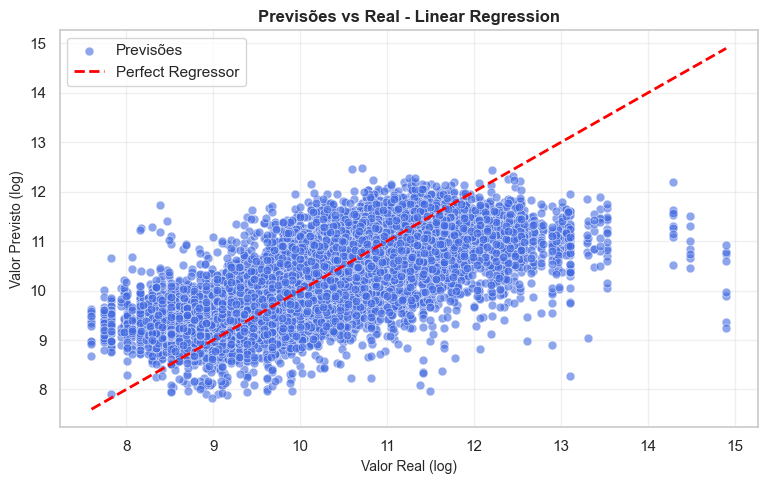

In [28]:
n_modelos = len(modelos_treinados)
n_cols = 2
n_rows = (n_modelos + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# CORREÇÃO: Converter 'axes' num array 1D de forma robusta
# Se houver apenas 1 plot, axes é um objeto. Se houver vários, é um array.
# ravel() garante que temos sempre uma lista plana de eixos.
axes_flat = np.atleast_1d(axes).ravel()

for idx, (nome_modelo, info_modelo) in enumerate(modelos_treinados.items()):
    grafico_dispersao(
        nome_modelo=nome_modelo,
        modelo_obj=info_modelo['modelo'],
        X_val=X_val,
        y_val=y_val,
        usar_scaled_viz=info_modelo['usar_scaled'],
        X_val_scaled=X_val_scaled,
        ax=axes_flat[idx]
    )

# Remover subplots vazios (caso o número de modelos seja ímpar)
for idx in range(n_modelos, len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()
plt.show()

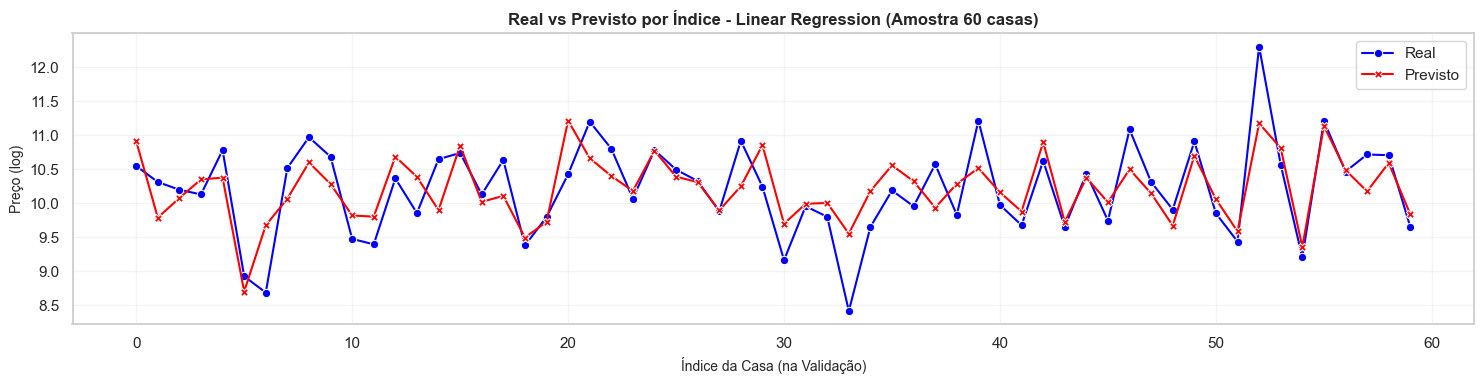

In [37]:
sns.set_theme(style="whitegrid")

n_modelos = len(modelos_treinados)
n_cols = 1 # Alterado para 1 coluna para as linhas ficarem mais largas e legíveis
n_rows = n_modelos

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Garantir que axes é iterável
axes_flat = np.atleast_1d(axes).ravel()

for idx, (nome_modelo, info_modelo) in enumerate(modelos_treinados.items()):
    grafico_comparativo_por_indice(
        nome_modelo=nome_modelo,
        modelo_obj=info_modelo['modelo'],
        X_val=X_val,
        y_val=y_val,
        usar_scaled_viz=info_modelo['usar_scaled'],
        X_val_scaled=X_val_scaled,
        ax=axes_flat[idx],
        n_amostra=60 # Podes ajustar este número para ver mais ou menos casas
    )

plt.tight_layout()
plt.show()

In [30]:
# Comparação final
print(f"\n\n{'='*80}")
print(" ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)")
print(f"{'='*80}\n")

# Criar o DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values('rmse_val', ascending=True)

print(df_resultados[['nome', 'rmse_val']].to_string(index=False))

# Melhor modelo
melhor_resultado = df_resultados.iloc[0]

print(f"\n\n ▶ MELHOR MODELO: {melhor_resultado['nome']}")
print(f"   RMSE Validação: {melhor_resultado['rmse_val']:,.4f}")



 ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)

             nome  rmse_val
Linear Regression  0.552294


 ▶ MELHOR MODELO: Linear Regression
   RMSE Validação: 0.5523


---
# 3. Salvar Submissão & Fazer Log do Modelo

### Método para **guardar log das configurações do modelo**

In [31]:
def salvar_submissao_log(df_sub, modelo_treinado, nome_modelo, metricas):
    pasta = 'submissoes'
    os.makedirs(pasta, exist_ok=True)

    # Descobrir o próximo ID de submissão
    ficheiros = os.listdir(pasta)
    ids_existentes = []
    for f in ficheiros:
        if f.startswith('submission_') and f.endswith('.csv'):
            if f == "Historico_Resultados.csv": continue
            try:
                numero_str = f.replace('submission_', '').replace('.csv', '')
                ids_existentes.append(int(numero_str))
            except ValueError:
                continue
    
    next_id = max(ids_existentes) + 1 if ids_existentes else 1
    
    nome_arquivo_sub = f"submission_{next_id}.csv"
    path_csv_submissao = os.path.join(pasta, nome_arquivo_sub)
    path_log_geral = os.path.join(pasta, "Historico_Resultados.csv")

    # Salvar submissão
    df_sub.to_csv(path_csv_submissao, index=False)

    # Extrair Hiperparâmetros
    try:
        params = modelo_treinado.get_params()
    except:
        params = {"info": "Não foi possível extrair params"}

    
    dados_log = {
        "id_submissao": next_id,
        "ficheiro_submissao": nome_arquivo_sub,
        "Algoritmo": metricas['nome'],        
        "Treino RMSE": metricas['rmse_train'],
        "Validação RMSE": metricas['rmse_val'],
        "hiperparametros": str(params)
    }
        
    df_novo_registo = pd.DataFrame([dados_log])

    if os.path.exists(path_log_geral):
        df_novo_registo.to_csv(path_log_geral, mode='a', header=False, index=False)
    else:
        df_novo_registo.to_csv(path_log_geral, index=False)

    print(f"\n✓ Submissão #{next_id} finalizada!")
    print(f" ▱ Ficheiro de submissão: {path_csv_submissao}")
    print(f" ▱ Histórico atualizado em: {path_log_geral}")

In [32]:
# Obter dados do melhor modelo do DataFrame de resultados
melhor_modelo_nome = melhor_resultado['nome'] # Alterado de 'modelo' para 'nome'
melhor_modelo = modelos_treinados[melhor_modelo_nome]['modelo']
usar_scaled = modelos_treinados[melhor_modelo_nome]['usar_scaled']

# Escolher o conjunto de teste correto
X_test_usar = X_test_scaled if usar_scaled else X_test_aligned

# Fazer previsões
pred_log = melhor_modelo.predict(X_test_usar)


pred_reais = np.exp(pred_log) 

# Criar DataFrame de submissão
df_submissao = pd.DataFrame({
    'id': df_teste.index,
    'price': pred_reais
})

# Chamar a função de salvamento
salvar_submissao_log(df_submissao, melhor_modelo, melhor_modelo_nome, melhor_resultado.to_dict())


✓ Submissão #44 finalizada!
 ▱ Ficheiro de submissão: submissoes\submission_44.csv
 ▱ Histórico atualizado em: submissoes\Historico_Resultados.csv
